In [1]:
import os
import kagglehub
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim import SGD
from torch.utils.data import Dataset,DataLoader
torch.manual_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
path=kagglehub.dataset_download("zalando-research/fashionmnist")

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [4]:
os.listdir(path)

['t10k-labels-idx1-ubyte',
 't10k-images-idx3-ubyte',
 'fashion-mnist_test.csv',
 'fashion-mnist_train.csv',
 'train-labels-idx1-ubyte',
 'train-images-idx3-ubyte']

In [5]:
train_df=pd.read_csv(path + "/fashion-mnist_train.csv")
test_df=pd.read_csv(path + "/fashion-mnist_test.csv")

In [6]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


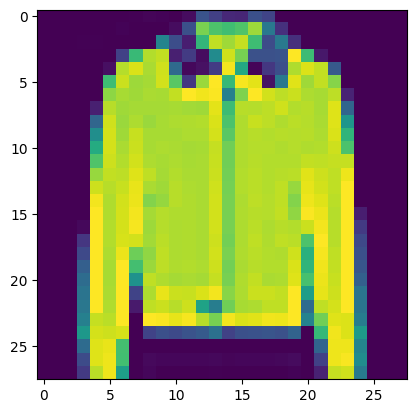

In [84]:
sk=train_df.drop("label",axis=1)
plt.imshow(sk.loc[266].values.reshape(28,28))

In [7]:
X=train_df.drop("label",axis=1).values
y=train_df["label"].values

In [8]:
X_=test_df.drop("label",axis=1).values
y_=test_df["label"].values
X_=X_/255.0
y_=y_/255.0

In [9]:
X=X/255.0
y=y/255.0

In [10]:
class CustomDataset(Dataset):
    def __init__(self,features,label):
        self.features=torch.tensor(features,dtype=torch.float32)
        self.label=torch.tensor(label,dtype=torch.long)
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self,index):
        return self.features[index],self.label[index]

In [11]:
train_dataset=CustomDataset(X,y)
test_dataset=CustomDataset(X_,y_)

In [12]:
train_loader=DataLoader(train_dataset,batch_size=100,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=100,shuffle=True,pin_memory=True)

In [60]:
class MyNN(nn.Module):
    def __init__(self,n_features):
        super().__init__()
        self.n_features=n_features
        self.network=nn.Sequential(
            nn.Linear(self.n_features,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
    def forward(self,X):
        return self.network(X)

In [61]:
criterion=nn.CrossEntropyLoss()
model=MyNN(X.shape[1])
model=model.to(device)
optimizer=SGD(model.parameters(),lr=0.1)

In [62]:
for epoch in range(10):
    total_epoch_loss=0
    for x,y in train_loader:
        x,y=x.to(device),y.to(device)
        outputs=model(x)
        loss=criterion(outputs,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_epoch_loss+=loss.item()
    avg=total_epoch_loss/len(train_loader)
    print(f"epochs: {epoch+1} with loss: {avg}")

epochs: 1 with loss: 0.01580135402996954
epochs: 2 with loss: 0.00020676706753685418
epochs: 3 with loss: 0.0001137606941233571
epochs: 4 with loss: 7.796493139513435e-05
epochs: 5 with loss: 5.90162830122883e-05
epochs: 6 with loss: 4.731740423018494e-05
epochs: 7 with loss: 3.939483880472494e-05
epochs: 8 with loss: 3.368510367000255e-05
epochs: 9 with loss: 2.938031813590906e-05
epochs: 10 with loss: 2.6025767108552128e-05


In [63]:
model.eval()

MyNN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [64]:
total=0
correct=0
with torch.no_grad():
    for x,y in test_loader:
        x,y=x.to(device),y.to(device)
        output=model(x)
        _,predicted=torch.max(output,1)
        total+=x.shape[0]
        correct+=(predicted==y).float().sum().item()
    print(correct/total)

1.0


In [65]:
xx=torch.tensor(X_[1:101],dtype=torch.float32)

In [66]:
len(xx)

100

In [79]:
y_[1:101]*255

array([1., 2., 2., 3., 2., 8., 6., 5., 0., 3., 4., 4., 6., 8., 5., 6., 3.,
       6., 4., 4., 4., 2., 1., 5., 7., 8., 4., 4., 1., 5., 7., 7., 8., 1.,
       0., 9., 8., 0., 8., 2., 0., 4., 6., 2., 0., 3., 3., 2., 3., 2., 2.,
       9., 3., 0., 9., 9., 4., 6., 0., 4., 5., 4., 6., 1., 1., 0., 9., 5.,
       2., 7., 3., 4., 6., 5., 7., 1., 6., 1., 4., 9., 8., 1., 2., 4., 8.,
       9., 4., 1., 6., 3., 4., 2., 2., 2., 6., 4., 7., 7., 3., 9.])

In [71]:
yy=model(xx.to(device))

In [72]:
predicted=torch.argmax(yy,dim=1)

In [73]:
predicted

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')

In [80]:
xx = torch.tensor(X_[1:101], dtype=torch.float32) / 255.0
xx = xx.to(device)

with torch.no_grad():
    yy = model(xx)
    predicted = torch.argmax(yy, dim=1)

predicted

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')